In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# /kaggle/input/neuclass/NEU Metal Surface Defects Data/
train_dir = '/kaggle/input/neuclass/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neuclass/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neuclass/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neuclass/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neuclass/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neuclass/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neuclass/NEU Metal Surface Defects Data/valid"))



Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


In [5]:

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')




Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [6]:

#Using transfer learning
from tensorflow.keras.applications import resnet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = keras.applications.resnet.ResNet101(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(200,200,3),
    pooling=None)

2022-03-01 11:57:14.939894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 11:57:15.053672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 11:57:15.054810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 11:57:15.056492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

171458560/171446536 [==============================] - 2s 0us/step


In [7]:
base_model.trainable = False # Freeze the base_model

In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 94,041,990
Trainable params: 51,383,814
Non-trainable params: 42,658,176
_________________________________________________________________


In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [13]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-03-01 11:57:49.654132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-01 11:57:54.484749: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 11s 68ms/step - loss: 2.9512 - accuracy: 0.0972
initial loss: 2.95
initial accuracy: 0.10


In [15]:
callbacks = myCallback()
history = model.fit(train_generator, epochs=initial_epochs,
                    validation_data=validation_generator, callbacks=[callbacks],
                    verbose=1, shuffle=True)

Epoch 1/10
166/166 [==============================] - 20s 121ms/step - loss: 0.7005 - accuracy: 0.7464 - val_loss: 0.9156 - val_accuracy: 0.6944
Epoch 2/10
166/166 [==============================] - 19s 117ms/step - loss: 0.7542 - accuracy: 0.7210 - val_loss: 0.5675 - val_accuracy: 0.8472
Epoch 3/10
166/166 [==============================] - 20s 120ms/step - loss: 0.6675 - accuracy: 0.7566 - val_loss: 0.6774 - val_accuracy: 0.6528
Epoch 4/10
166/166 [==============================] - 20s 118ms/step - loss: 0.7390 - accuracy: 0.7222 - val_loss: 0.4931 - val_accuracy: 0.8333
Epoch 5/10
166/166 [==============================] - 19s 116ms/step - loss: 0.6597 - accuracy: 0.7548 - val_loss: 0.5531 - val_accuracy: 0.8333
Epoch 6/10
166/166 [==============================] - 20s 120ms/step - loss: 0.7455 - accuracy: 0.7295 - val_loss: 0.3791 - val_accuracy: 0.8611
Epoch 7/10
166/166 [==============================] - 19s 116ms/step - loss: 0.6146 - accuracy: 0.7705 - val_loss: 0.4410 - val_ac

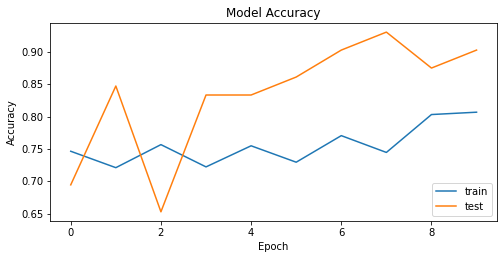

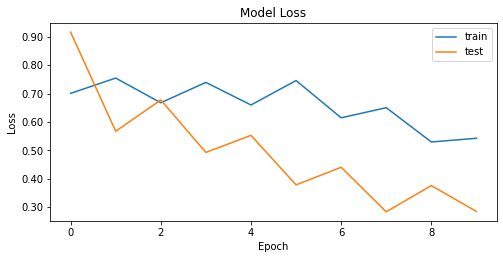

In [16]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(8, 8))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


# summarize history for accuracy  
plt.subplot(211)  
plt.plot(acc)  
plt.plot(val_acc)  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places 
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='lower right')  

plt.figure(figsize=(8, 8)) 

# summarize history for loss     
plt.subplot(212)  
plt.plot(loss)  
plt.plot(val_loss)  
plt.title('Model Loss')  
plt.ylabel('Loss') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places 
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.show()

In [17]:
from keras.models import load_model
model.save('my_model.h5') # save the entire model with trained weights
new_model = load_model('my_model.h5') # load this model with its weights

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  345


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 94,041,990
Trainable params: 51,383,814
Non-trainable params: 42,658,176
_________________________________________________________________


In [21]:
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#learning_rate reduce module
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=4, 
                                              factor=0.5, min_lr=1e-6)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=4,
                              verbose=0, restore_best_weights=True)

In [22]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         batch_size = 32,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[lr_reduce, early_stopper],
                         verbose=1, shuffle=True)

Epoch 10/20
166/166 [==============================] - 29s 134ms/step - loss: 0.3529 - accuracy: 0.8841 - val_loss: 0.2299 - val_accuracy: 0.9167
Epoch 11/20
166/166 [==============================] - 19s 116ms/step - loss: 0.3606 - accuracy: 0.8883 - val_loss: 0.2191 - val_accuracy: 0.9306
Epoch 12/20
166/166 [==============================] - 20s 120ms/step - loss: 0.3550 - accuracy: 0.8937 - val_loss: 0.2189 - val_accuracy: 0.9306
Epoch 13/20
166/166 [==============================] - 20s 120ms/step - loss: 0.3544 - accuracy: 0.8901 - val_loss: 0.2213 - val_accuracy: 0.9306
Epoch 14/20
166/166 [==============================] - 19s 114ms/step - loss: 0.3593 - accuracy: 0.8889 - val_loss: 0.2196 - val_accuracy: 0.9306
Epoch 15/20
166/166 [==============================] - 20s 119ms/step - loss: 0.3522 - accuracy: 0.8901 - val_loss: 0.2206 - val_accuracy: 0.9306
Epoch 16/20
166/166 [==============================] - 19s 116ms/step - loss: 0.3365 - accuracy: 0.8931 - val_loss: 0.2190 -

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

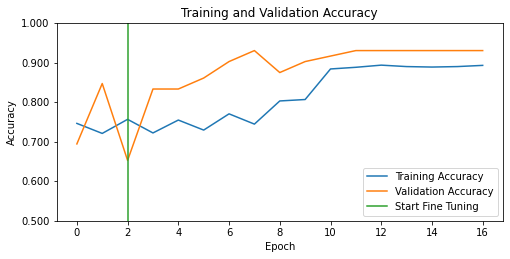

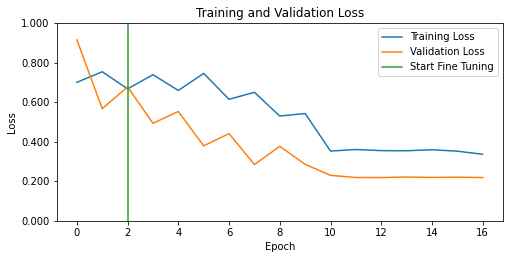

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.00])
plt.plot([initial_epochs-8,initial_epochs-8],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 3 decimal places 
plt.xlabel('Epoch')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-8,initial_epochs-8],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 3 decimal places 
plt.xlabel('Epoch')
plt.show()

In [29]:
# First, we are going to load the file names and their respective target labels into numpy array! 
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [30]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [31]:
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [32]:
# We just have the file names in the x set. Let's load the images and convert them into array.
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [33]:
x_test = x_test.astype('float32')/255

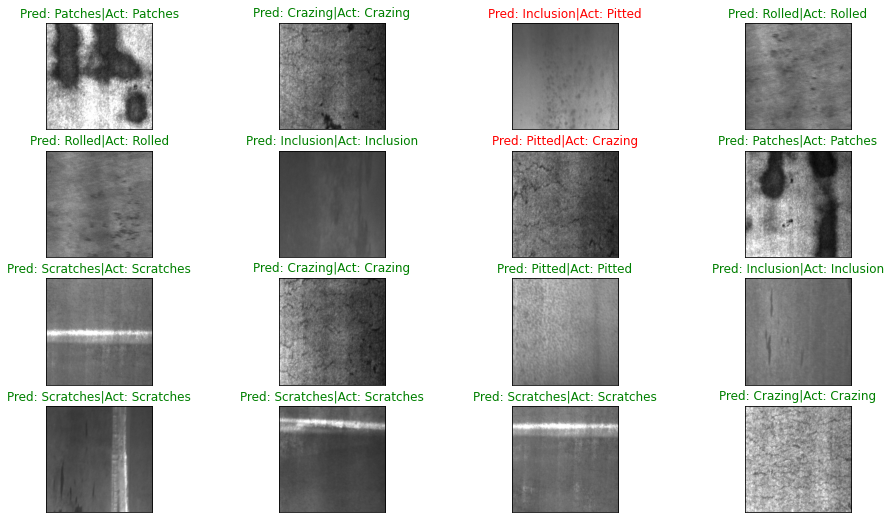

In [34]:
# Let's visualize test prediction.
y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("Pred: {}|Act: {}".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [36]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load the image
img = load_img('../input/neuclass/NEU Metal Surface Defects Data/test/Patches/Pa_105.bmp', target_size=(200, 200))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 200, 200, 3)
# center pixel data
img = img.astype('float32')/255
 
# predict the class
result = model.predict(img)
print('This metal has',target_labels[np.argmax(result)])

This metal has Patches
